In [1]:
import zipfile
import pandas as pd
import os
import re

# Directory where the ZIP files are located
base_directory = '../../data/raw/itineraries_csv/'

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Define a regular expression pattern to match filenames ending with two lowercase letters
file_pattern = re.compile(r'.*[a-z][a-z]\.zip')

# List all airport folders in the base directory
airport_names = [name for name in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, name))]

dfs = []  # Create a list to store DataFrames

for airport_name in airport_names:
    # Directory path for the current airport
    zip_directory = os.path.join(base_directory, airport_name)
    
    # List all files in the airport's folder
    file_list = os.listdir(zip_directory)

    for filename in file_list:
        if file_pattern.match(filename):
            zip_file_path = os.path.join(zip_directory, filename)
            csv_file_path_inside_zip = filename.replace('.zip', '.csv')
            
            # Create a ZipFile object and read the CSV file
            with zipfile.ZipFile(zip_file_path, 'r') as zf:
                df = pd.read_csv(zf.open(csv_file_path_inside_zip))

            # Append the DataFrame for this filename to the list of DataFrames
            dfs.append(df)

# Use pandas.concat to concatenate the list of DataFrames into a single DataFrame
all_airport = pd.concat(dfs, ignore_index=True)

## Feature Engineering

In [2]:
all_airport['flightDate'] = pd.to_datetime(all_airport['flightDate'])

In [3]:
all_airport['searchDate'] = pd.to_datetime(all_airport['searchDate'])

## 1. dateDifference

`days = flightDate- searchDate` show how many day before book the flight

For streamlit we might can use the get current date and do flightDate - currentDate

In [4]:
# Calculate the date difference and create a new column 'dateDifference'
all_airport['dateDifference'] =all_airport['flightDate'] - all_airport['searchDate']

In [5]:
all_airport['dateDifference'] = all_airport['dateDifference'].dt.days

In [6]:
all_airport['dateDifference'].unique()

array([31, 32, 33, 20, 21, 34, 35,  7,  8,  9, 51, 52, 53, 45, 46, 54, 55,
       37, 38,  4,  5, 23, 24, 25, 13, 14, 15, 16, 17, 58, 59, 26, 47, 48,
       36,  6,  1, 27, 49, 50, 42, 43, 44, 28, 29, 39, 40, 56, 57, 60, 10,
       22, 11, 30, 18, 19,  2,  3, 12, 41])

In [7]:
all_airport['dateDifference'].sample(10)

1783139     51
12487230    28
11529065    27
7680252      1
5593487      3
3046128     29
167834      43
3951503     54
2561179     38
5376210     18
Name: dateDifference, dtype: int64

## List for legs

In [8]:
all_airport['segmentsAirlineCode'] = all_airport['segmentsAirlineCode'].apply(lambda x: re.split(r'\|\|', x))

In [9]:
all_airport['segmentsAirlineCode'].sample(10)

11854337    [DL, DL]
6807254         [DL]
3616771     [AA, AA]
1889297     [DL, DL]
5338674         [B6]
12668628        [AA]
417932          [NK]
7846709     [AA, AA]
12712147        [AA]
13048734    [UA, UA]
Name: segmentsAirlineCode, dtype: object

In [10]:
all_airport['segmentsAirlineCode'].apply(lambda x: len(x)).unique()

array([2, 3, 1, 4])

In [11]:
from datetime import datetime

In [13]:
# Split the column using '||' as the delimiter and convert to seconds
all_airport['segmentsDepartureTimeEpochSeconds'] = all_airport['segmentsDepartureTimeEpochSeconds'].str.split(r'\|\|').apply(lambda x: [int(value) for value in x])

# Convert the seconds to datetime objects
all_airport['segmentsDepartureTimeEpochSeconds'] = all_airport['segmentsDepartureTimeEpochSeconds'].apply(lambda x: [datetime.fromtimestamp(seconds) for seconds in x])


In [14]:
all_airport['segmentsDepartureTimeEpochSeconds']

0           [2022-05-21 11:58:00, 2022-05-21 16:53:00]
1           [2022-05-21 01:56:00, 2022-05-21 03:51:00]
2           [2022-05-20 23:05:00, 2022-05-21 03:51:00]
3           [2022-05-21 13:56:00, 2022-05-21 16:20:00]
4           [2022-05-21 14:41:00, 2022-05-22 00:00:00]
                               ...                    
13519994    [2022-06-15 22:05:00, 2022-06-16 07:05:00]
13519995    [2022-06-16 05:26:00, 2022-06-16 10:15:00]
13519996    [2022-06-16 01:15:00, 2022-06-16 06:55:00]
13519997    [2022-06-15 21:20:00, 2022-06-16 03:00:00]
13519998    [2022-06-15 21:20:00, 2022-06-16 06:55:00]
Name: segmentsDepartureTimeEpochSeconds, Length: 13519999, dtype: object

In [15]:
# Convert the list of datetime objects to a list of Unix timestamps (in seconds)
all_airport['segmentsDepartureTimeEpochSeconds'] = all_airport['segmentsDepartureTimeEpochSeconds'].apply(lambda x: [int(dt.timestamp()) for dt in x])


In [16]:
all_airport['segmentsDepartureTimeEpochSeconds']

0           [1653098280, 1653115980]
1           [1653062160, 1653069060]
2           [1653051900, 1653069060]
3           [1653105360, 1653114000]
4           [1653108060, 1653141600]
                      ...           
13519994    [1655294700, 1655327100]
13519995    [1655321160, 1655338500]
13519996    [1655306100, 1655326500]
13519997    [1655292000, 1655312400]
13519998    [1655292000, 1655326500]
Name: segmentsDepartureTimeEpochSeconds, Length: 13519999, dtype: object

In [ ]:
columns = ['segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode']

In [ ]:
selected_columns = all_airport[columns]

In [ ]:
selected_columns

,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,1653098280||1653115980,2022-05-20T18:58:00.000-07:00||2022-05-21T00:5...,1653107460||1653126600,2022-05-20T22:31:00.000-06:00||2022-05-21T05:5...,DEN||ATL,OAK||DEN,Frontier Airlines||Frontier Airlines,F9||F9,||Airbus A320,9180||10620,943||1207,"[coach, coach]"
1,1653062160||1653069060,2022-05-20T08:56:00.000-07:00||2022-05-20T10:5...,1653067080||1653084660,2022-05-20T10:18:00.000-07:00||2022-05-20T18:1...,LAX||ATL,OAK||LAX,Spirit Airlines||Spirit Airlines,NK||NK,||AIRBUS INDUSTRIE A320 SHARKLETS,4920||15600,None||None,"[coach, coach]"
2,1653051900||1653069060,2022-05-20T06:05:00.000-07:00||2022-05-20T10:5...,1653056820||1653084660,2022-05-20T07:27:00.000-07:00||2022-05-20T18:1...,LAX||ATL,OAK||LAX,Spirit Airlines||Spirit Airlines,NK||NK,AIRBUS INDUSTRIE A320 SHARKLETS||AIRBUS INDUST...,4920||15600,None||None,"[coach, coach]"
3,1653105360||1653114000,2022-05-20T20:56:00.000-07:00||2022-05-20T23:2...,1653110940||1653127980,2022-05-20T22:29:00.000-07:00||2022-05-21T06:1...,LAS||ATL,OAK||LAS,Spirit Airlines||Spirit Airlines,NK||NK,AIRBUS INDUSTRIE A320 SHARKLETS||Airbus A319,5580||13980,None||None,"[coach, coach]"
4,1653108060||1653141600,2022-05-20T21:41:00.000-07:00||2022-05-21T07:0...,1653115560||1653159180,2022-05-20T23:46:00.000-07:00||2022-05-21T14:5...,SEA||ATL,OAK||SEA,Alaska Airlines||Alaska Airlines,AS||AS,Boeing 737-900||Boeing 737-900,7500||17580,672||2178,"[coach, coach]"
...,...,...,...,...,...,...,...,...,...,...,...,...
13519994,1655294700||1655327100,2022-06-15T08:05:00.000-04:00||2022-06-15T17:0...,1655301420||1655345400,2022-06-15T09:57:00.000-04:00||2022-06-15T19:1...,ATL||SFO,MIA||ATL,Delta||Delta,DL||DL,Boeing 757||Boeing 757-300,6720||18300,596||2135,"[coach, coach]"
13519995,1655321160||1655338500,2022-06-15T15:26:00.000-04:00||2022-06-15T20:1...,1655333100||1655361840,2022-06-15T18:45:00.000-04:00||2022-06-15T23:4...,JFK||SFO,MIA||JFK,Delta||Alaska Airlines,DL||AS,Boeing 737-800||AIRBUS INDUSTRIE A321 SHARKLETS,11940||23340,1104||2566,"[coach, coach]"
13519996,1655306100||1655326500,2022-06-15T11:15:00.000-04:00||2022-06-15T16:5...,1655317200||1655349900,2022-06-15T14:20:00.000-04:00||2022-06-15T20:2...,JFK||SFO,MIA||JFK,Delta||Alaska Airlines,DL||AS,Boeing 737-800||Boeing 737-900,11100||23400,1104||2566,"[coach, coach]"
13519997,1655292000||1655312400,2022-06-15T07:20:00.000-04:00||2022-06-15T13:0...,1655302800||1655335800,2022-06-15T10:20:00.000-04:00||2022-06-15T16:3...,JFK||SFO,MIA||JFK,Delta||Alaska Airlines,DL||AS,Boeing 737-800||AIRBUS INDUSTRIE A321 SHARKLETS,10800||23400,1104||2566,"[coach, coach]"


In [ ]:
all_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13519999 entries, 0 to 13519998
Data columns (total 23 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   legId                              object 
 1   searchDate                         object 
 2   flightDate                         object 
 3   startingAirport                    object 
 4   destinationAirport                 object 
 5   travelDuration                     object 
 6   isBasicEconomy                     bool   
 7   isRefundable                       bool   
 8   isNonStop                          bool   
 9   totalFare                          float64
 10  totalTravelDistance                float64
 11  segmentsDepartureTimeEpochSeconds  object 
 12  segmentsDepartureTimeRaw           object 
 13  segmentsArrivalTimeEpochSeconds    object 
 14  segmentsArrivalTimeRaw             object 
 15  segmentsArrivalAirportCode         object 
 16  segmentsDepartur

## Split with regular expression

In [ ]:
columns = ['segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
           'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
           'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineCode',
           'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
           'segmentsDistance', 'segmentsCabinCode']

In [ ]:
# # Apply the split operation to each column using a lambda function
# for column in columns:
#     all_airport[column] = all_airport[column].apply(lambda x: re.split(r'\|\|', x))

In [ ]:
# all_airport.describe()

,totalFare,totalTravelDistance
count,1.352000e+07,1.256038e+07
mean,3.737535e+02,1.569619e+03
std,2.075496e+02,8.414888e+02
min,2.397000e+01,9.700000e+01
25%,2.235800e+02,8.620000e+02
50%,3.446000e+02,1.392000e+03
75%,4.876000e+02,2.376000e+03
max,8.260610e+03,4.430000e+03


- legId                                      0
- searchDate                                0
- flightDate                                0
- startingAirport                           0
- destinationAirport                        0
- travelDuration                            0
- isBasicEconomy                            0
isRefundable                              0
totalFare                                 0 (y)
totalTravelDistance                  959619
segmentsDepartureTimeEpochSeconds         0
segmentsArrivalTimeEpochSeconds           0
segmentsArrivalAirportCode                0
segmentsDepartureAirportCode              0
segmentsAirlineCode                       0
segmentsEquipmentDescription         262676
segmentsDurationInSeconds                 0 -> sum
segmentsDistance                          0 -> sum
segmentsCabinCode                         0
-------
travelLayover (travelDuration - segmentsDurationInSeconds)
datediff (flightDate - searchDate)
transitAirportCode (list) -> check arrival departure 
numberOfTransit -> count (transitAirportCode)

## Visualisation

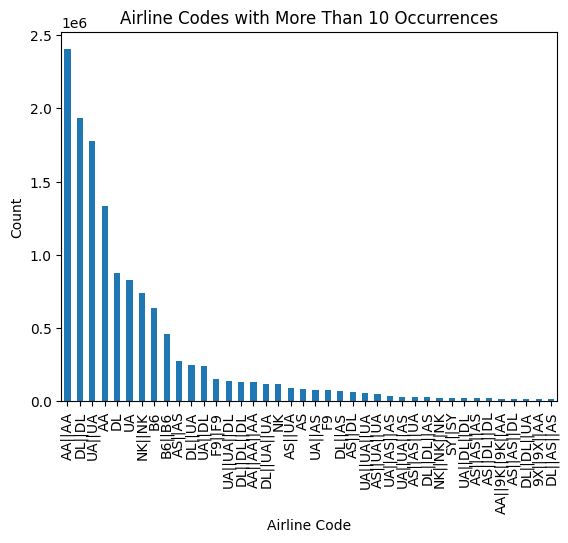

In [ ]:
import matplotlib.pyplot as plt
# Calculate the value counts for 'segmentsAirlineCode'
value_counts = all_airport['segmentsAirlineCode'].value_counts()

# Filter for values with more than 10 counts
filtered_value_counts = value_counts[value_counts > 10000]

# Create a bar plot for the filtered value counts
filtered_value_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Airline Code')
plt.ylabel('Count')
plt.title('Airline Codes with More Than 10 Occurrences')

# Show the plot
plt.show()

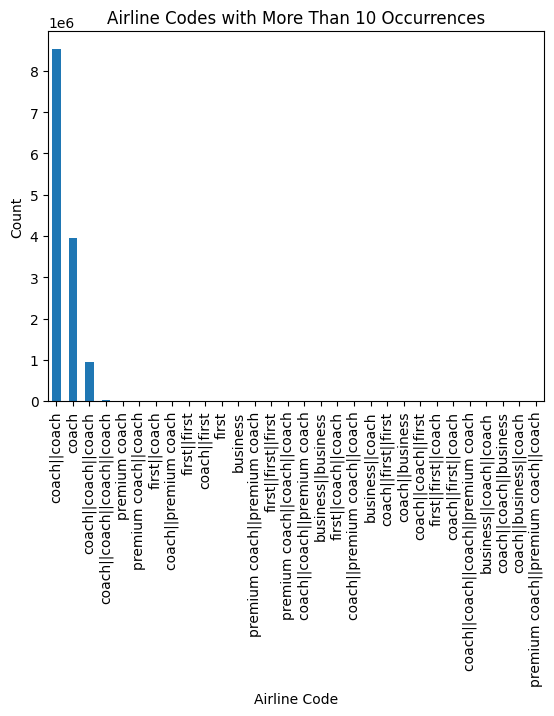

In [ ]:
import matplotlib.pyplot as plt
# Calculate the value counts for 'segmentsAirlineCode'
value_counts = all_airport['segmentsCabinCode'].value_counts()

# Filter for values with more than 10 counts
filtered_value_counts = value_counts[value_counts > 100]

# Create a bar plot for the filtered value counts
filtered_value_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Airline Code')
plt.ylabel('Count')
plt.title('Airline Codes with More Than 10 Occurrences')

# Show the plot
plt.show()